# Análisis de explicabilidad (XAI) por dataset – ResNet-18

En este notebook se analizan las explicaciones generadas por distintos métodos XAI
(Grad-CAM, Grad-CAM++, Integrated Gradients y Saliency) aplicados a **tres modelos
ResNet-18 independientes**:

- `blood`  → modelo entrenado solo con BloodMNIST (8 clases).
- `retina` → modelo entrenado solo con RetinaMNIST (5 clases).
- `breast` → modelo entrenado solo con BreastMNIST (2 clases).

Las explicaciones no se calculan aquí, sino que se han generado previamente desde
terminal ejecutando el script:

```bash
python xai_explanations.py --model_path results/best_model_blood.pth  --dataset blood  ...
python xai_explanations.py --model_path results/best_model_retina.pth --dataset retina ...
python xai_explanations.py --model_path results/best_model_breast.pth --dataset breast ...


In [21]:
# Configuración y rutas

from pathlib import Path
import pandas as pd
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import sys


# Ruta del proyecto
PROJECT_DIR = Path("/home/TFM_Laura_Monne").resolve()
RESULTS_DIR = PROJECT_DIR / "results"
OUTPUTS_DIR = PROJECT_DIR / "outputs"

print("Proyecto :", PROJECT_DIR)
print("Resultados:", RESULTS_DIR)
print("Outputs   :", OUTPUTS_DIR)
print("Dataset   :", DATASET)

assert RESULTS_DIR.exists(), "❌ Falta la carpeta results/ (entrena primero con train.py)"
assert OUTPUTS_DIR.exists(), "❌ Falta la carpeta outputs/ (ejecuta primero python xai_explanations.py)"

# Aseguramos que los módulos locales (prepare_data, data_utils, resnet18) se puedan importar
if str(PROJECT_DIR) not in sys.path:
    sys.path.append(str(PROJECT_DIR))

Proyecto : /home/TFM_Laura_Monne
Resultados: /home/TFM_Laura_Monne/results
Outputs   : /home/TFM_Laura_Monne/outputs
Dataset   : blood


In [22]:
# Carga de las explicaciones XAI por dataset

import os

# Nombres esperados de los JSON generados por xai_explanations.py
JSON_FILES = {
    "blood":  OUTPUTS_DIR / "explanations_blood.json",
    "retina": OUTPUTS_DIR / "explanations_retina.json",
    "breast": OUTPUTS_DIR / "explanations_breast.json",
}

explanations_by_dataset = {}

for ds_name, json_path in JSON_FILES.items():
    assert json_path.exists(), f"❌ No se encuentra {json_path}. Genera primero las explicaciones para {ds_name}."
    with open(json_path, "r") as f:
        explanations_by_dataset[ds_name] = json.load(f)
    print(f"{ds_name.upper():6s} -> {len(explanations_by_dataset[ds_name])} muestras explicadas")


BLOOD  -> 500 muestras explicadas
RETINA -> 400 muestras explicadas
BREAST -> 156 muestras explicadas


In [23]:
"""
En esta celda resumimos, para cada dataset (blood, retina, breast):

- nº de muestras explicadas (entradas en su JSON)
- nº de predicciones correctas (true_class == pred_class)
- accuracy (%) dentro de las muestras explicadas
"""

rows = []

for ds_name, exps in explanations_by_dataset.items():
    n = len(exps)
    correct = sum(1 for obj in exps if obj["true_class"] == obj["pred_class"])
    acc = (correct / n * 100) if n > 0 else float("nan")

    rows.append({
        "Dataset": ds_name.upper(),
        "Muestras explicadas": n,
        "Predicciones correctas": correct,
        "Accuracy dentro de las explicaciones (%)": round(acc, 2),
    })

df_xai_summary = pd.DataFrame(rows)
print("Resumen de explicaciones por dataset:")
display(df_xai_summary)


Resumen de explicaciones por dataset:


,Dataset,Muestras explicadas,Predicciones correctas,Accuracy dentro de las explicaciones (%)
0,BLOOD,500,487,97.40
1,RETINA,400,160,40.00
2,BREAST,156,127,81.41


In [24]:
import random

def choose_example(bucket: str, correct: bool = True):
    """
    Devuelve una muestra del dataset 'bucket' (blood/retina/breast)
    con predicción correcta o incorrecta según 'correct'.
    """
    exps = explanations_by_dataset[bucket]  # usamos el diccionario que creaste al inicio
    candidates = []
    for obj in exps:
        is_correct = (obj["true_class"] == obj["pred_class"])
        if is_correct == correct:
            candidates.append(obj)

    if not candidates:
        return None
    return random.choice(candidates)

def show_explanations(example):
    """
    Muestra los mapas XAI (Grad-CAM, Grad-CAM++, IG, Saliency)
    de una entrada del JSON.
    """
    if example is None:
        print("⚠️ No hay ejemplo disponible con ese criterio.")
        return

    bucket = example.get("bucket", "desconocido")
    y_true = example["true_class"]
    y_pred = example["pred_class"]
    methods = example["methods"]

    print(f"Dataset (bucket): {bucket}")
    print(f"Clase real      : {y_true}")
    print(f"Clase predicha  : {y_pred}")
    print("Métodos XAI disponibles:", list(methods.keys()))

    n_methods = len(methods)
    plt.figure(figsize=(4 * n_methods, 4))

    for i, (name, info) in enumerate(methods.items()):
        path_rel = info.get("path")  # por ejemplo: 'outputs/gradcam/img_0_class_3.png'
        img_path = PROJECT_DIR / path_rel

        plt.subplot(1, n_methods, i + 1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis("off")
        plt.title(name.upper())

    plt.tight_layout()
    plt.show()


Ejemplo CORRECTO - BLOOD
Dataset (bucket): blood
Clase real      : 4
Clase predicha  : 4
Métodos XAI disponibles: ['gradcam', 'gradcampp', 'integrated_gradients', 'saliency']


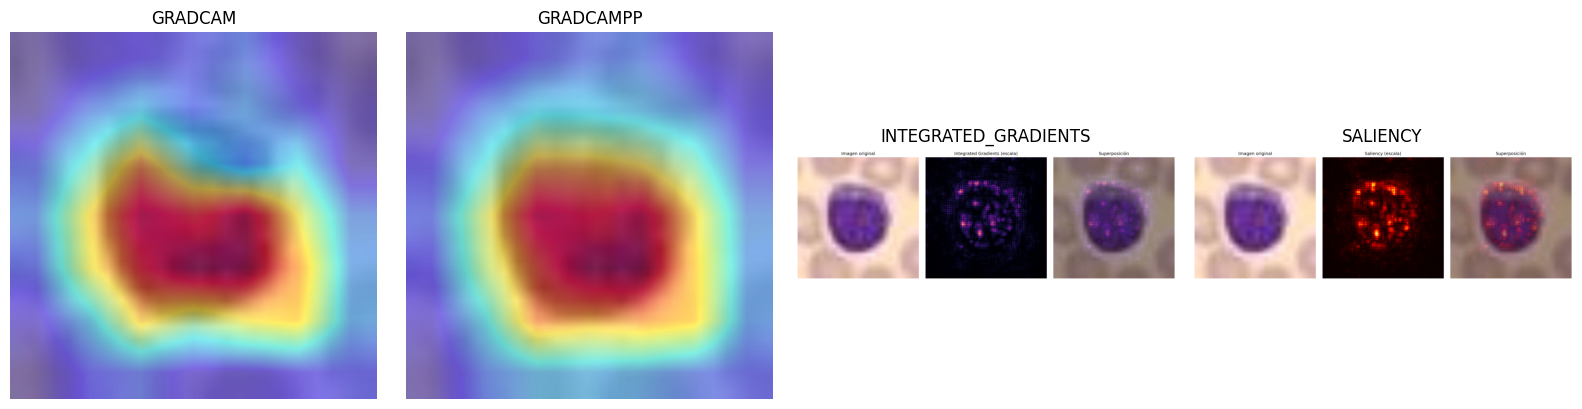


Ejemplo CORRECTO - RETINA
Dataset (bucket): retina
Clase real      : 0
Clase predicha  : 0
Métodos XAI disponibles: ['gradcam', 'gradcampp', 'integrated_gradients', 'saliency']


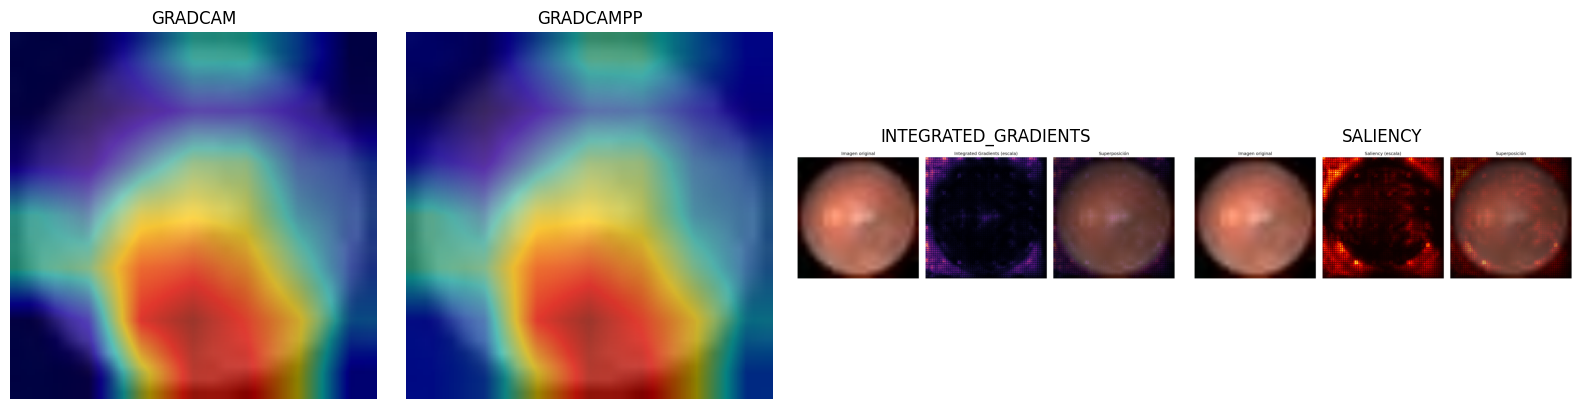


Ejemplo CORRECTO - BREAST
Dataset (bucket): breast
Clase real      : 1
Clase predicha  : 1
Métodos XAI disponibles: ['gradcam', 'gradcampp', 'integrated_gradients', 'saliency']


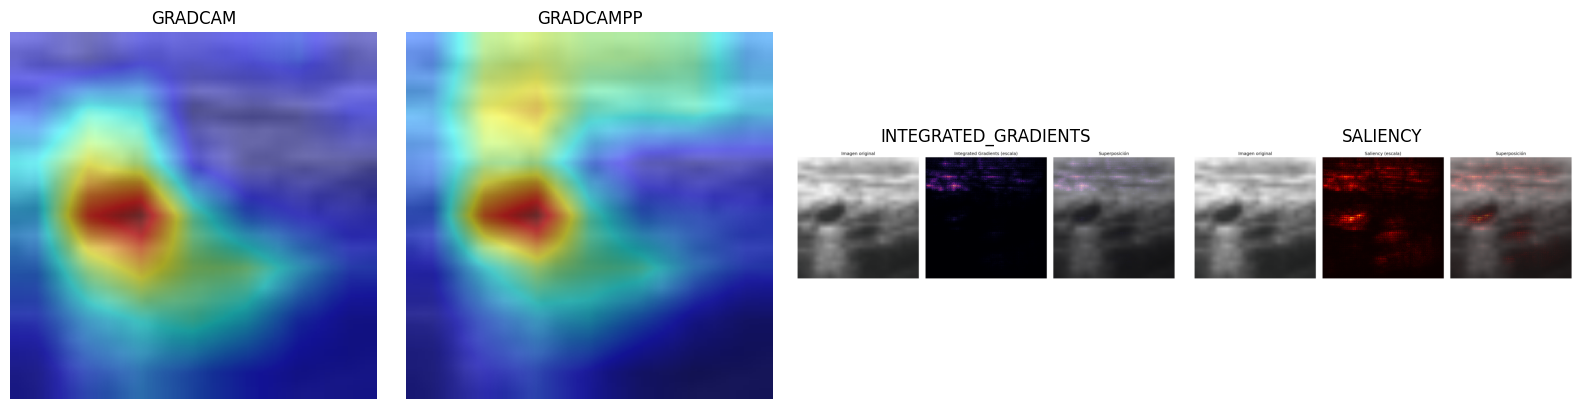

In [25]:
"""
Ejemplos de predicciones CORRECTAS para cada modelo (blood, retina, breast).
"""

for bucket in ["blood", "retina", "breast"]:
    print("\n" + "=" * 30)
    print(f"Ejemplo CORRECTO - {bucket.upper()}")
    print("=" * 30)
    ex = choose_example(bucket=bucket, correct=True)
    show_explanations(ex)



Ejemplo INCORRECTO - BLOOD
Dataset (bucket): blood
Clase real      : 3
Clase predicha  : 4
Métodos XAI disponibles: ['gradcam', 'gradcampp', 'integrated_gradients', 'saliency']


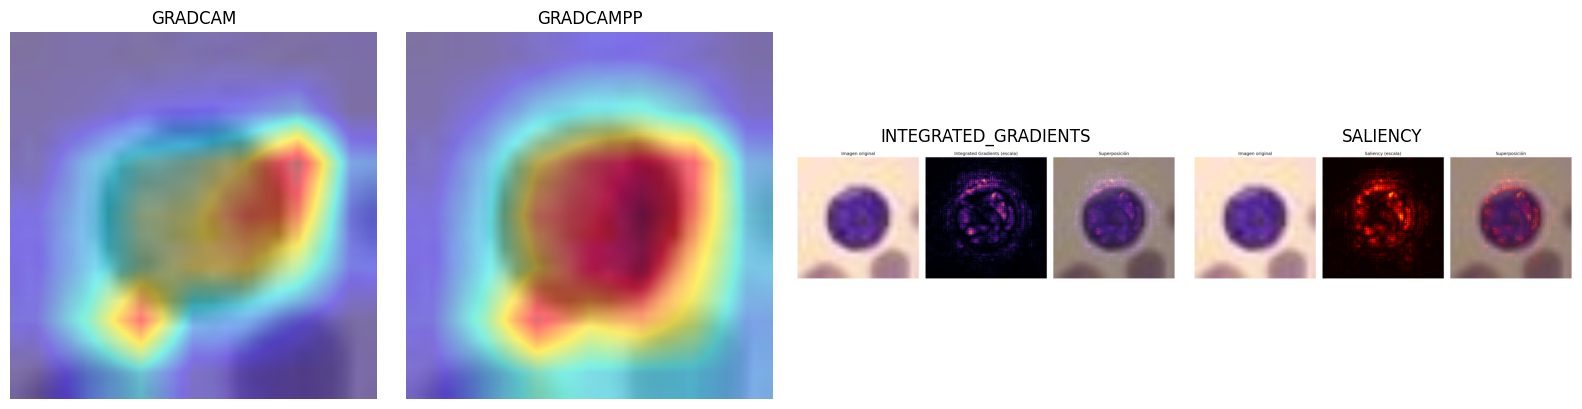


Ejemplo INCORRECTO - RETINA
Dataset (bucket): retina
Clase real      : 0
Clase predicha  : 1
Métodos XAI disponibles: ['gradcam', 'gradcampp', 'integrated_gradients', 'saliency']


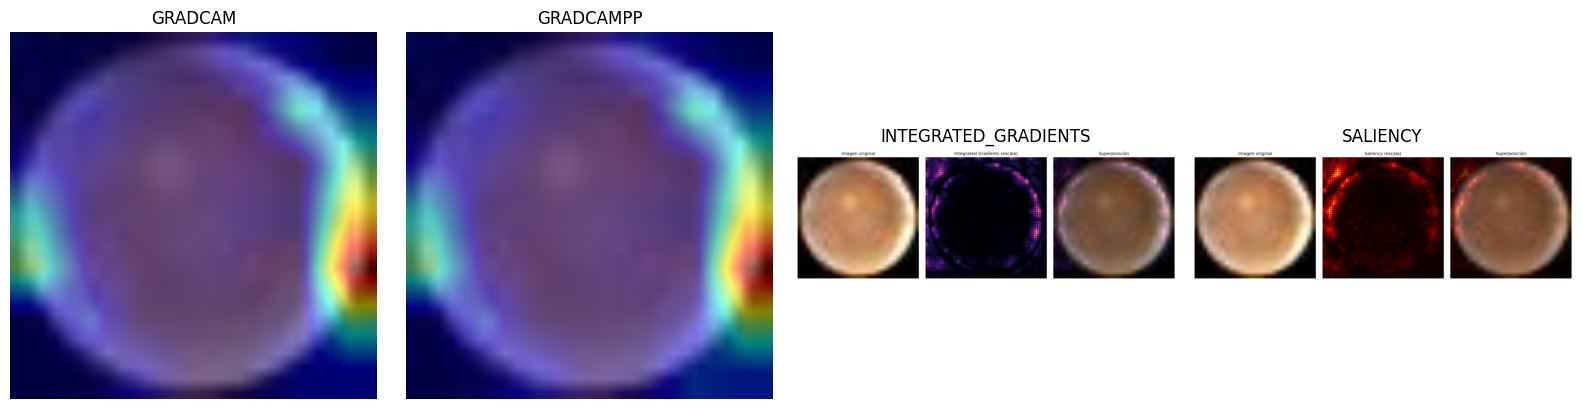


Ejemplo INCORRECTO - BREAST
Dataset (bucket): breast
Clase real      : 0
Clase predicha  : 1
Métodos XAI disponibles: ['gradcam', 'gradcampp', 'integrated_gradients', 'saliency']


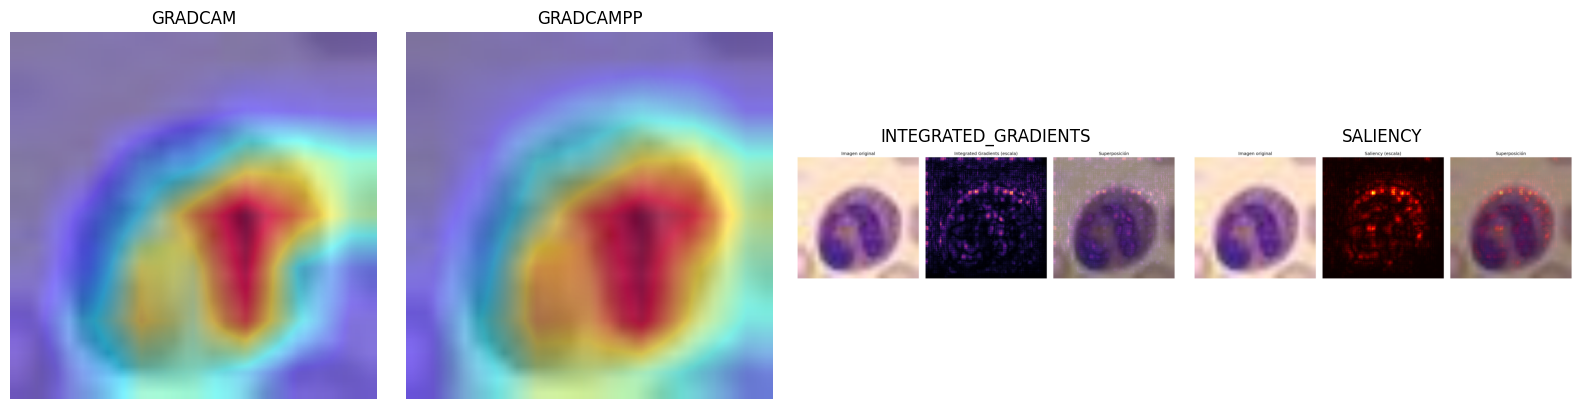

In [26]:
"""
Ejemplos de predicciones INCORRECTAS para cada modelo (si existen).
Muy útil para comentar en el TFM dónde se equivoca cada modelo.
"""

for bucket in ["blood", "retina", "breast"]:
    print("\n" + "=" * 30)
    print(f"Ejemplo INCORRECTO - {bucket.upper()}")
    print("=" * 30)
    ex = choose_example(bucket=bucket, correct=False)
    show_explanations(ex)
